# Instalación libreria

In [ ]:
pip install gurobipy

# Análisis de casos

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1862 rows, 1568 columns and 11595 nonzeros
Model fingerprint: 0xbcbad125
Variable types: 484 continuous, 1084 integer (1084 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 902 rows and 230 columns
Presolve time: 0.08s
Presolved: 960 rows, 1338 columns, 7994 nonzeros
Variable types: 431 continuous, 907 integer (907 binary)

Root relaxation: objective 1.620000e+00, 318 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.62000    0   19        

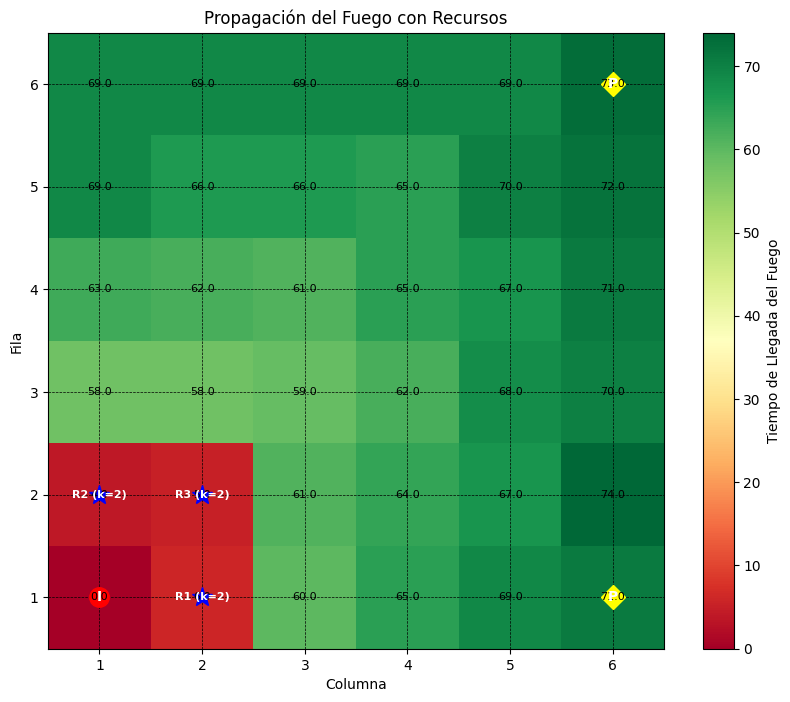

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Definimos los parámetros del problema
grid_size = 6  # Tamaño de la cuadrícula
N = [(i, j) for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)]  # Nodos en una cuadrícula grid_size x grid_size

# Arcos entre nodos adyacentes con ocho direcciones de propagación
A = []
for i, j in N:
    # Ocho direcciones de propagación
    directions = [
        (1, 0),   # Este
        (-1, 0),  # Oeste
        (0, 1),   # Norte
        (0, -1),  # Sur
        (1, 1),   # Noreste
        (1, -1),  # Sureste
        (-1, 1),  # Noroeste
        (-1, -1)  # Suroeste
    ]

    for dx, dy in directions:
        new_i, new_j = i + dx, j + dy
        if 1 <= new_i <= grid_size and 1 <= new_j <= grid_size:
            A.append(((i, j), (new_i, new_j)))

# Función para calcular tiempo de propagación considerando viento, pendiente y aleatoriedad
def calculate_propagation_time(dx, dy):
    # Simulando los tres factores mencionados en el paper
    wind_factor = 1 if dx > 0 or dy > 0 else 3
    slope_factor = np.random.randint(1, 4)
    fuel_factor = np.random.randint(1, 4)

    base_time = wind_factor + slope_factor + fuel_factor
    return base_time

# Tiempo de propagación entre nodos
c = {((i_start, j_start), (i_end, j_end)): calculate_propagation_time(i_end - i_start, j_end - j_start)
     for (i_start, j_start), (i_end, j_end) in A}

# Nodo de ignición del fuego
ignition_node = (1, 1)

# Nodos que deben ser protegidos
P = [(6, 6),(1,6)]

# Valor g (tiempo mínimo que el fuego debe tardar en llegar a los nodos protegidos)
g = 50  # Ajusta este valor según sea necesario

# Conjunto de recursos disponibles
R = [1, 2, 3]

# Delta: tiempo que se retrasa la propagación al colocar un recurso
Delta =50  # Tiempo de retraso significativo

# Definimos el conjunto de instantes de tiempo
T = 8  # Número total de periodos de tiempo
K = range(1, T+1)

# Parámetros de disponibilidad de recursos
a_k = {k: 0 for k in K}
a_k[2] = len(R)  # Todos los recursos disponibles en k=2

# Parámetros de instantes de tiempo
b_k = {k: k for k in K}  # Cada periodo representa una unidad de tiempo

# Creamos el modelo de optimización
m = gp.Model("Areas_Protegidas")

# Variables de decisión
# t_i: tiempo de llegada del fuego al nodo i
t = m.addVars(range(1, grid_size + 1), range(1, grid_size + 1), name="t", lb=0)

# s_ij: variables de holgura
s = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="s", lb=0
)

# q_ij: variables binarias para el flujo en el arco ij
q = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], vtype=GRB.BINARY, name="q"
)

# x_ij: variables de flujo
x = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="x", lb=0
)

# z_{ri}^k: variables binarias que indican si el recurso r está ubicado en el nodo i en el tiempo k
z = m.addVars(
    R, range(1, grid_size + 1), range(1, grid_size + 1), K, vtype=GRB.BINARY, name="z"
)

# o_k: recursos no utilizados en el tiempo k
o = m.addVars(K, lb=0, name="o")

# Función objetivo: minimizar el número total de recursos utilizados
m.setObjective(
    gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K),
    GRB.MINIMIZE
)

# Restricciones base de flujo y propagación

# Restricción (2): Conservación de flujo en el nodo de ignición
m.addConstr(
    -gp.quicksum(x[ignition_node[0], ignition_node[1], j[0], j[1]] for (i, j) in A if i == ignition_node) == -(len(N) - 1),
    name="FlowConservation_Ignition"
)

# Restricción (3): Conservación de flujo en los demás nodos
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        if (i, j) != ignition_node:
            m.addConstr(
                -gp.quicksum(x[i, j, k, l] for (start, (k, l)) in A if start == (i, j)) +
                gp.quicksum(x[k, l, i, j] for ((k, l), end) in A if end == (i, j)) == 1,
                name=f"FlowConservation_{i}_{j}"
            )

# Restricción (7): Tiempo de llegada en el nodo de ignición
m.addConstr(t[ignition_node[0], ignition_node[1]] == 0, name="IgnitionTime")

# Restricción (11): x_{ij} ≤ (n-1) q_{ij}
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        x[i_start, j_start, i_end, j_end] <= (len(N) - 1) * q[i_start, j_start, i_end, j_end],
        name=f"FlowLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (21): Tiempo de llegada considerando la ubicación de recursos
for (i_start, j_start), (i_end, j_end) in A:
    resource_delay = Delta * gp.quicksum(z[r, i_start, j_start, k] for r in R for k in K)
    m.addConstr(
        t[i_end, j_end] - t[i_start, j_start] + s[i_start, j_start, i_end, j_end] ==
        c[((i_start, j_start), (i_end, j_end))] + resource_delay,
        name=f"TimeArrival_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (22): s_{ij} ≤ M (1 - q_{ij})
M = (len(N) - 1) * max(c.values()) + len(R) * Delta
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        s[i_start, j_start, i_end, j_end] <= M * (1 - q[i_start, j_start, i_end, j_end]),
        name=f"SlackLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricciones de recursos

# Restricción (14): Cada recurso puede ubicarse en un solo nodo y tiempo
for r in R:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K) <= 1,
        name=f"Resource_{r}_UniqueLocation"
    )

# Restricción (15): Un nodo puede tener como máximo un recurso en un tiempo dado
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        for k in K:
            m.addConstr(
                gp.quicksum(z[r, i, j, k] for r in R) <= 1,
                name=f"Node_{i}_{j}_SingleResource_Time_{k}"
            )

# Restricción (16): Disponibilidad de recursos en tiempo inicial
m.addConstr(
    gp.quicksum(z[r, i, j, 1] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[1] == a_k[1],
    name="ResourceAvailability_1"
)

# Restricción (17): Disponibilidad de recursos en tiempos posteriores
for k in K[1:]:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[k] == a_k[k] + o[k-1],
        name=f"ResourceAvailability_{k}"
    )

# Restricción (18): Los recursos solo pueden asignarse a nodos no quemados antes del tiempo b_k
for r in R:
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            for k in K:
                m.addConstr(
                    t[i, j] >= b_k[k] * z[r, i, j, k],
                    name=f"ResourceUsage_{r}_{i}_{j}_{k}"
                )

# Restricción (24): Los nodos protegidos deben tener un tiempo de llegada mayor o igual a g
for i, j in P:
    m.addConstr(t[i, j] >= g, name=f"ProtectedNode_{i}_{j}")

# Resolución del modelo
m.optimize()

# Visualización
if m.status == GRB.OPTIMAL:
    print("\nSolución Óptima Encontrada:")
    print(f"Número mínimo de recursos utilizados: {m.objVal}")

    # Extracción de ubicaciones de recursos
    resource_locations = {}
    for r in R:
        for k in K:
            for i in range(1, grid_size + 1):
                for j in range(1, grid_size + 1):
                    if z[r, i, j, k].X > 0.5:
                        resource_locations[r] = (i, j, k)
                        print(f"Recurso {r} ubicado en el nodo ({i}, {j}) en el tiempo {k}")
                        break

    # Tiempos de llegada del fuego a cada nodo
    arrival_times = {(i, j): t[i, j].X for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)}

    # Matriz de tiempos de llegada
    time_grid = np.zeros((grid_size, grid_size))
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            time_grid[grid_size - i, j - 1] = arrival_times[(i, j)]

    # Visualización
    plt.figure(figsize=(10, 8))
    plt.imshow(time_grid, cmap='RdYlGn')
    plt.colorbar(label='Tiempo de Llegada del Fuego')
    plt.title('Propagación del Fuego con Recursos')
    plt.xlabel('Columna')
    plt.ylabel('Fila')
    plt.xticks(range(grid_size), range(1, grid_size + 1))
    plt.yticks(range(grid_size), range(grid_size, 0, -1))

    # Etiquetas de nodos
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{time_grid[i, j]:.1f}",
                     ha='center', va='center', color='black', fontsize=8)

# Marcar nodos de recursos:
    for (r, (x, y, k)) in resource_locations.items():
        plt.plot(y - 1, grid_size - x, marker='*', color='blue', markersize=15)
        plt.text(y - 1, grid_size - x, f'R{r} (k={k})', color='white',
                ha='center', va='center', fontsize=8, fontweight='bold')
    # Marcar nodo de ignición
    plt.plot(ignition_node[1] - 1, grid_size - ignition_node[0], 'ro', markersize=14, label='Ignición')  # Círculo rojo
    plt.text(ignition_node[1] - 1, grid_size - ignition_node[0], 'I', color='white',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Marcar nodos protegidos
    for (i, j) in P:
        plt.plot(j - 1, grid_size - i, marker='D', color='yellow', markersize=12)  # Cambiar a rombo
        plt.text(j - 1, grid_size - i, 'P', color='white',
                ha='center', va='center', fontsize=10, fontweight='bold')
    plt.grid(which='both', color='black', linewidth=0.5, linestyle='--')
    plt.show()
else:
    print("No se encontró una solución óptima.")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1861 rows, 1568 columns and 11589 nonzeros
Model fingerprint: 0x589dc46e
Variable types: 484 continuous, 1084 integer (1084 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 1029 rows and 284 columns
Presolve time: 0.22s
Presolved: 832 rows, 1284 columns, 6300 nonzeros
Variable types: 334 continuous, 950 integer (949 binary)

Root relaxation: objective 1.800000e+00, 234 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.80000    0   15       

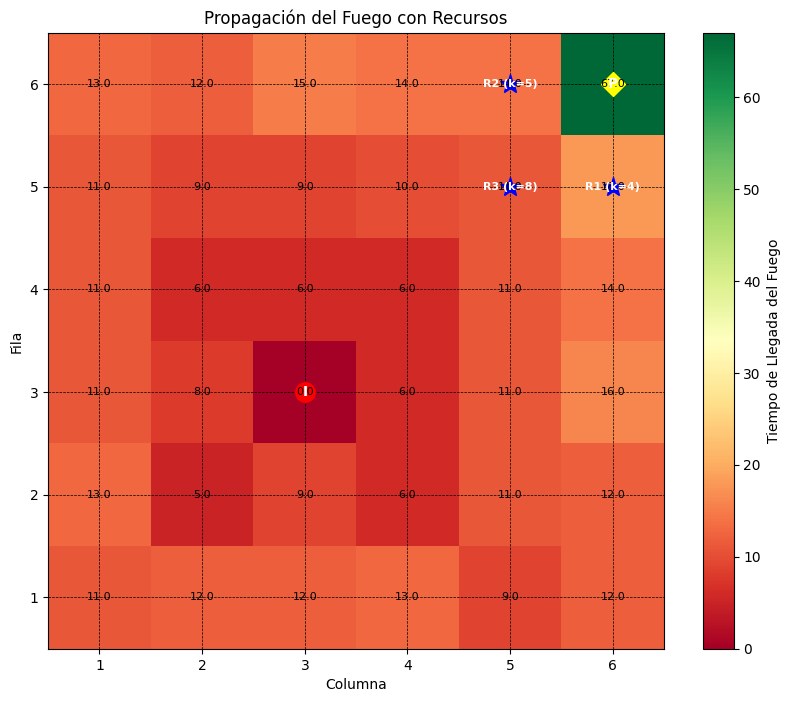

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Definimos los parámetros del problema
grid_size = 6  # Tamaño de la cuadrícula
N = [(i, j) for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)]  # Nodos en una cuadrícula grid_size x grid_size

# Arcos entre nodos adyacentes con ocho direcciones de propagación
A = []
for i, j in N:
    # Ocho direcciones de propagación
    directions = [
        (1, 0),   # Este
        (-1, 0),  # Oeste
        (0, 1),   # Norte
        (0, -1),  # Sur
        (1, 1),   # Noreste
        (1, -1),  # Sureste
        (-1, 1),  # Noroeste
        (-1, -1)  # Suroeste
    ]

    for dx, dy in directions:
        new_i, new_j = i + dx, j + dy
        if 1 <= new_i <= grid_size and 1 <= new_j <= grid_size:
            A.append(((i, j), (new_i, new_j)))

# Función para calcular tiempo de propagación considerando viento, pendiente y aleatoriedad
def calculate_propagation_time(dx, dy):
    # Simulando los tres factores mencionados en el paper
    wind_factor = 1 if dx > 0 or dy > 0 else 3
    slope_factor = np.random.randint(1, 4)
    fuel_factor = np.random.randint(1, 4)

    base_time = wind_factor + slope_factor + fuel_factor
    return base_time

# Tiempo de propagación entre nodos
c = {((i_start, j_start), (i_end, j_end)): calculate_propagation_time(i_end - i_start, j_end - j_start)
     for (i_start, j_start), (i_end, j_end) in A}

# Nodo de ignición del fuego
ignition_node = (3, 3)

# Nodos que deben ser protegidos
P = [(6, 6)]

# Valor g (tiempo mínimo que el fuego debe tardar en llegar a los nodos protegidos)
g = 50

# Conjunto de recursos disponibles
R = [1, 2, 3]

# Delta
Delta =50

# Definimos el conjunto de instantes de tiempo
T = 8  # Número total de periodos de tiempo
K = range(1, T+1)

# Parámetros de disponibilidad de recursos
a_k = {k: 0 for k in K}
a_k[1] = len(R)  # Todos los recursos disponibles en k=2

# Parámetros de instantes de tiempo
b_k = {k: k for k in K}  # Cada periodo representa una unidad de tiempo

# Creamos el modelo de optimización
m = gp.Model("Areas_Protegidas")

# Variables de decisión
# t_i: tiempo de llegada del fuego al nodo i
t = m.addVars(range(1, grid_size + 1), range(1, grid_size + 1), name="t", lb=0)

# s_ij: variables de holgura
s = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="s", lb=0
)

# q_ij: variables binarias para el flujo en el arco ij
q = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], vtype=GRB.BINARY, name="q"
)

# x_ij: variables de flujo
x = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="x", lb=0
)

# z_{ri}^k: variables binarias que indican si el recurso r está ubicado en el nodo i en el tiempo k
z = m.addVars(
    R, range(1, grid_size + 1), range(1, grid_size + 1), K, vtype=GRB.BINARY, name="z"
)

# o_k: recursos no utilizados en el tiempo k
o = m.addVars(K, lb=0, name="o")

# Función objetivo: minimizar el número total de recursos utilizados
m.setObjective(
    gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K),
    GRB.MINIMIZE
)

# Restricciones base de flujo y propagación

# Restricción (2): Conservación de flujo en el nodo de ignición
m.addConstr(
    -gp.quicksum(x[ignition_node[0], ignition_node[1], j[0], j[1]] for (i, j) in A if i == ignition_node) == -(len(N) - 1),
    name="FlowConservation_Ignition"
)

# Restricción (3): Conservación de flujo en los demás nodos
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        if (i, j) != ignition_node:
            m.addConstr(
                -gp.quicksum(x[i, j, k, l] for (start, (k, l)) in A if start == (i, j)) +
                gp.quicksum(x[k, l, i, j] for ((k, l), end) in A if end == (i, j)) == 1,
                name=f"FlowConservation_{i}_{j}"
            )

# Restricción (7): Tiempo de llegada en el nodo de ignición
m.addConstr(t[ignition_node[0], ignition_node[1]] == 0, name="IgnitionTime")

# Restricción (11): x_{ij} ≤ (n-1) q_{ij}
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        x[i_start, j_start, i_end, j_end] <= (len(N) - 1) * q[i_start, j_start, i_end, j_end],
        name=f"FlowLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (21): Tiempo de llegada considerando la ubicación de recursos
for (i_start, j_start), (i_end, j_end) in A:
    resource_delay = Delta * gp.quicksum(z[r, i_start, j_start, k] for r in R for k in K)
    m.addConstr(
        t[i_end, j_end] - t[i_start, j_start] + s[i_start, j_start, i_end, j_end] ==
        c[((i_start, j_start), (i_end, j_end))] + resource_delay,
        name=f"TimeArrival_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (22): s_{ij} ≤ M (1 - q_{ij})
M = (len(N) - 1) * max(c.values()) + len(R) * Delta
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        s[i_start, j_start, i_end, j_end] <= M * (1 - q[i_start, j_start, i_end, j_end]),
        name=f"SlackLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricciones de recursos

# Restricción (14): Cada recurso puede ubicarse en un solo nodo y tiempo
for r in R:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K) <= 1,
        name=f"Resource_{r}_UniqueLocation"
    )

# Restricción (15): Un nodo puede tener como máximo un recurso en un tiempo dado
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        for k in K:
            m.addConstr(
                gp.quicksum(z[r, i, j, k] for r in R) <= 1,
                name=f"Node_{i}_{j}_SingleResource_Time_{k}"
            )

# Restricción (16): Disponibilidad de recursos en tiempo inicial
m.addConstr(
    gp.quicksum(z[r, i, j, 1] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[1] == a_k[1],
    name="ResourceAvailability_1"
)

# Restricción (17): Disponibilidad de recursos en tiempos posteriores
for k in K[1:]:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[k] == a_k[k] + o[k-1],
        name=f"ResourceAvailability_{k}"
    )

# Restricción (18): Los recursos solo pueden asignarse a nodos no quemados antes del tiempo b_k
for r in R:
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            for k in K:
                m.addConstr(
                    t[i, j] >= b_k[k] * z[r, i, j, k],
                    name=f"ResourceUsage_{r}_{i}_{j}_{k}"
                )

# Restricción (24): Los nodos protegidos deben tener un tiempo de llegada mayor o igual a g
for i, j in P:
    m.addConstr(t[i, j] >= g, name=f"ProtectedNode_{i}_{j}")

# Resolución del modelo
m.optimize()

# Visualización
if m.status == GRB.OPTIMAL:
    print("\nSolución Óptima Encontrada:")
    print(f"Número mínimo de recursos utilizados: {m.objVal}")

    # Extracción de ubicaciones de recursos
    resource_locations = {}
    for r in R:
        for k in K:
            for i in range(1, grid_size + 1):
                for j in range(1, grid_size + 1):
                    if z[r, i, j, k].X > 0.5:
                        resource_locations[r] = (i, j, k)
                        print(f"Recurso {r} ubicado en el nodo ({i}, {j}) en el tiempo {k}")
                        break

    # Tiempos de llegada del fuego a cada nodo
    arrival_times = {(i, j): t[i, j].X for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)}

    # Matriz de tiempos de llegada
    time_grid = np.zeros((grid_size, grid_size))
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            time_grid[grid_size - i, j - 1] = arrival_times[(i, j)]

    # Visualización
    plt.figure(figsize=(10, 8))
    plt.imshow(time_grid, cmap='RdYlGn')
    plt.colorbar(label='Tiempo de Llegada del Fuego')
    plt.title('Propagación del Fuego con Recursos')
    plt.xlabel('Columna')
    plt.ylabel('Fila')
    plt.xticks(range(grid_size), range(1, grid_size + 1))
    plt.yticks(range(grid_size), range(grid_size, 0, -1))

    # Etiquetas de nodos
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{time_grid[i, j]:.1f}",
                     ha='center', va='center', color='black', fontsize=8)

# Marcar nodos de recursos:
    for (r, (x, y, k)) in resource_locations.items():
        plt.plot(y - 1, grid_size - x, marker='*', color='blue', markersize=15)
        plt.text(y - 1, grid_size - x, f'R{r} (k={k})', color='white',
                ha='center', va='center', fontsize=8, fontweight='bold')
    # Marcar nodo de ignición
    plt.plot(ignition_node[1] - 1, grid_size - ignition_node[0], 'ro', markersize=14, label='Ignición')
    plt.text(ignition_node[1] - 1, grid_size - ignition_node[0], 'I', color='white',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Marcar nodos protegidos
    for (i, j) in P:
        plt.plot(j - 1, grid_size - i, marker='D', color='yellow', markersize=12)
        plt.text(j - 1, grid_size - i, 'P', color='white',
                ha='center', va='center', fontsize=10, fontweight='bold')
    plt.grid(which='both', color='black', linewidth=0.5, linestyle='--')
    plt.show()
else:
    print("No se encontró una solución óptima.")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1861 rows, 1568 columns and 11594 nonzeros
Model fingerprint: 0xc83b805e
Variable types: 484 continuous, 1084 integer (1084 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 861 rows and 121 columns
Presolve time: 0.14s
Presolved: 1000 rows, 1447 columns, 8821 nonzeros
Variable types: 432 continuous, 1015 integer (1015 binary)

Root relaxation: objective 2.060000e+00, 241 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.06000    0   22     

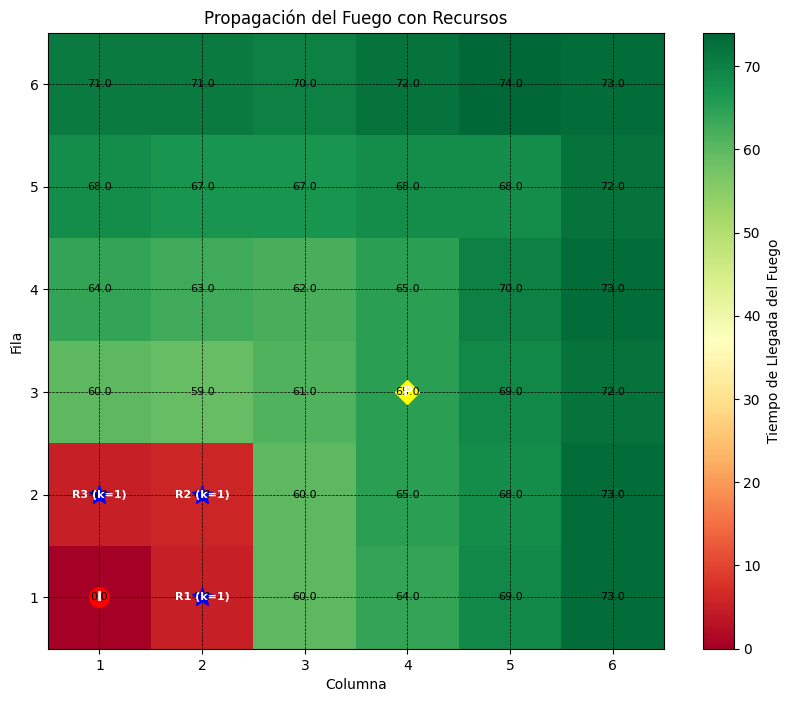

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Definimos los parámetros del problema
grid_size = 6  # Tamaño de la cuadrícula
N = [(i, j) for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)]  # Nodos en una cuadrícula grid_size x grid_size

# Arcos entre nodos adyacentes con ocho direcciones de propagación
A = []
for i, j in N:
    # Ocho direcciones de propagación
    directions = [
        (1, 0),   # Este
        (-1, 0),  # Oeste
        (0, 1),   # Norte
        (0, -1),  # Sur
        (1, 1),   # Noreste
        (1, -1),  # Sureste
        (-1, 1),  # Noroeste
        (-1, -1)  # Suroeste
    ]

    for dx, dy in directions:
        new_i, new_j = i + dx, j + dy
        if 1 <= new_i <= grid_size and 1 <= new_j <= grid_size:
            A.append(((i, j), (new_i, new_j)))

# Función para calcular tiempo de propagación considerando viento, pendiente y aleatoriedad
def calculate_propagation_time(dx, dy):
    # Simulando los tres factores mencionados en el paper
    wind_factor = 1 if dx > 0 or dy > 0 else 3
    slope_factor = np.random.randint(1, 4)
    fuel_factor = np.random.randint(1, 4)

    base_time = wind_factor + slope_factor + fuel_factor
    return base_time

# Tiempo de propagación entre nodos
c = {((i_start, j_start), (i_end, j_end)): calculate_propagation_time(i_end - i_start, j_end - j_start)
     for (i_start, j_start), (i_end, j_end) in A}

# Nodo de ignición del fuego
ignition_node = (1, 1)

# Nodos que deben ser protegidos
P = [(3, 4)]

# Valor g (tiempo mínimo que el fuego debe tardar en llegar a los nodos protegidos)
g = 50

# Conjunto de recursos disponibles
R = [1, 2, 3]

# Delta: tiempo que se retrasa la propagación al colocar un recurso
Delta =50

# Definimos el conjunto de instantes de tiempo
T = 8  # Número total de periodos de tiempo
K = range(1, T+1)

# Parámetros de disponibilidad de recursos
a_k = {k: 0 for k in K}
a_k[1] = len(R)

# Parámetros de instantes de tiempo
b_k = {k: k for k in K}  # Cada periodo representa una unidad de tiempo

# Creamos el modelo de optimización
m = gp.Model("Areas_Protegidas")

# Variables de decisión
# t_i: tiempo de llegada del fuego al nodo i
t = m.addVars(range(1, grid_size + 1), range(1, grid_size + 1), name="t", lb=0)

# s_ij: variables de holgura
s = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="s", lb=0
)

# q_ij: variables binarias para el flujo en el arco ij
q = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], vtype=GRB.BINARY, name="q"
)

# x_ij: variables de flujo
x = m.addVars(
    [(i[0], i[1], j[0], j[1]) for i, j in A], name="x", lb=0
)

# z_{ri}^k: variables binarias que indican si el recurso r está ubicado en el nodo i en el tiempo k
z = m.addVars(
    R, range(1, grid_size + 1), range(1, grid_size + 1), K, vtype=GRB.BINARY, name="z"
)

# o_k: recursos no utilizados en el tiempo k
o = m.addVars(K, lb=0, name="o")

# Función objetivo: minimizar el número total de recursos utilizados
m.setObjective(
    gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K),
    GRB.MINIMIZE
)

# Restricciones base de flujo y propagación

# Restricción (2): Conservación de flujo en el nodo de ignición
m.addConstr(
    -gp.quicksum(x[ignition_node[0], ignition_node[1], j[0], j[1]] for (i, j) in A if i == ignition_node) == -(len(N) - 1),
    name="FlowConservation_Ignition"
)

# Restricción (3): Conservación de flujo en los demás nodos
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        if (i, j) != ignition_node:
            m.addConstr(
                -gp.quicksum(x[i, j, k, l] for (start, (k, l)) in A if start == (i, j)) +
                gp.quicksum(x[k, l, i, j] for ((k, l), end) in A if end == (i, j)) == 1,
                name=f"FlowConservation_{i}_{j}"
            )

# Restricción (7): Tiempo de llegada en el nodo de ignición
m.addConstr(t[ignition_node[0], ignition_node[1]] == 0, name="IgnitionTime")

# Restricción (11): x_{ij} ≤ (n-1) q_{ij}
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        x[i_start, j_start, i_end, j_end] <= (len(N) - 1) * q[i_start, j_start, i_end, j_end],
        name=f"FlowLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (21): Tiempo de llegada considerando la ubicación de recursos
for (i_start, j_start), (i_end, j_end) in A:
    resource_delay = Delta * gp.quicksum(z[r, i_start, j_start, k] for r in R for k in K)
    m.addConstr(
        t[i_end, j_end] - t[i_start, j_start] + s[i_start, j_start, i_end, j_end] ==
        c[((i_start, j_start), (i_end, j_end))] + resource_delay,
        name=f"TimeArrival_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricción (22): s_{ij} ≤ M (1 - q_{ij})
M = (len(N) - 1) * max(c.values()) + len(R) * Delta
for (i_start, j_start), (i_end, j_end) in A:
    m.addConstr(
        s[i_start, j_start, i_end, j_end] <= M * (1 - q[i_start, j_start, i_end, j_end]),
        name=f"SlackLink_{i_start}_{j_start}_{i_end}_{j_end}"
    )

# Restricciones de recursos

# Restricción (14): Cada recurso puede ubicarse en un solo nodo y tiempo
for r in R:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K) <= 1,
        name=f"Resource_{r}_UniqueLocation"
    )

# Restricción (15): Un nodo puede tener como máximo un recurso en un tiempo dado
for i in range(1, grid_size + 1):
    for j in range(1, grid_size + 1):
        for k in K:
            m.addConstr(
                gp.quicksum(z[r, i, j, k] for r in R) <= 1,
                name=f"Node_{i}_{j}_SingleResource_Time_{k}"
            )

# Restricción (16): Disponibilidad de recursos en tiempo inicial
m.addConstr(
    gp.quicksum(z[r, i, j, 1] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[1] == a_k[1],
    name="ResourceAvailability_1"
)

# Restricción (17): Disponibilidad de recursos en tiempos posteriores
for k in K[1:]:
    m.addConstr(
        gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[k] == a_k[k] + o[k-1],
        name=f"ResourceAvailability_{k}"
    )

# Restricción (18): Los recursos solo pueden asignarse a nodos no quemados antes del tiempo b_k
for r in R:
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            for k in K:
                m.addConstr(
                    t[i, j] >= b_k[k] * z[r, i, j, k],
                    name=f"ResourceUsage_{r}_{i}_{j}_{k}"
                )

# Restricción (24): Los nodos protegidos deben tener un tiempo de llegada mayor o igual a g
for i, j in P:
    m.addConstr(t[i, j] >= g, name=f"ProtectedNode_{i}_{j}")

# Resolución del modelo
m.optimize()

# Visualización
if m.status == GRB.OPTIMAL:
    print("\nSolución Óptima Encontrada:")
    print(f"Número mínimo de recursos utilizados: {m.objVal}")

    # Extracción de ubicaciones de recursos
    resource_locations = {}
    for r in R:
        for k in K:
            for i in range(1, grid_size + 1):
                for j in range(1, grid_size + 1):
                    if z[r, i, j, k].X > 0.5:
                        resource_locations[r] = (i, j, k)
                        print(f"Recurso {r} ubicado en el nodo ({i}, {j}) en el tiempo {k}")
                        break

    # Tiempos de llegada del fuego a cada nodo
    arrival_times = {(i, j): t[i, j].X for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)}

    # Matriz de tiempos de llegada
    time_grid = np.zeros((grid_size, grid_size))
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            time_grid[grid_size - i, j - 1] = arrival_times[(i, j)]

    # Visualización
    plt.figure(figsize=(10, 8))
    plt.imshow(time_grid, cmap='RdYlGn')
    plt.colorbar(label='Tiempo de Llegada del Fuego')
    plt.title('Propagación del Fuego con Recursos')
    plt.xlabel('Columna')
    plt.ylabel('Fila')
    plt.xticks(range(grid_size), range(1, grid_size + 1))
    plt.yticks(range(grid_size), range(grid_size, 0, -1))

    # Etiquetas de nodos
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{time_grid[i, j]:.1f}",
                     ha='center', va='center', color='black', fontsize=8)

# Marcar nodos de recursos:
    for (r, (x, y, k)) in resource_locations.items():
        plt.plot(y - 1, grid_size - x, marker='*', color='blue', markersize=15)
        plt.text(y - 1, grid_size - x, f'R{r} (k={k})', color='white',
                ha='center', va='center', fontsize=8, fontweight='bold')
    # Marcar nodo de ignición
    plt.plot(ignition_node[1] - 1, grid_size - ignition_node[0], 'ro', markersize=14, label='Ignición')  # Círculo rojo
    plt.text(ignition_node[1] - 1, grid_size - ignition_node[0], 'I', color='white',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Marcar nodos protegidos
    for (i, j) in P:
        plt.plot(j - 1, grid_size - i, marker='D', color='yellow', markersize=12)  # Cambiar a rombo
        plt.text(j - 1, grid_size - i, 'P', color='white',
                ha='center', va='center', fontsize=10, fontweight='bold')
    plt.grid(which='both', color='black', linewidth=0.5, linestyle='--')
    plt.show()
else:
    print("No se encontró una solución óptima.")

# Análisis de delta


Solución Óptima Encontrada para Delta = 40:
Número mínimo de recursos utilizados: 3.0
Recurso 1 ubicado en el nodo (6, 5) en el tiempo 8
Recurso 2 ubicado en el nodo (5, 5) en el tiempo 5
Recurso 3 ubicado en el nodo (5, 6) en el tiempo 5

Solución Óptima Encontrada para Delta = 50:
Número mínimo de recursos utilizados: 3.0
Recurso 1 ubicado en el nodo (6, 5) en el tiempo 3
Recurso 2 ubicado en el nodo (5, 6) en el tiempo 3
Recurso 3 ubicado en el nodo (5, 5) en el tiempo 7

Solución Óptima Encontrada para Delta = 60:
Número mínimo de recursos utilizados: 3.0
Recurso 1 ubicado en el nodo (5, 5) en el tiempo 3
Recurso 2 ubicado en el nodo (6, 5) en el tiempo 1
Recurso 3 ubicado en el nodo (5, 6) en el tiempo 7


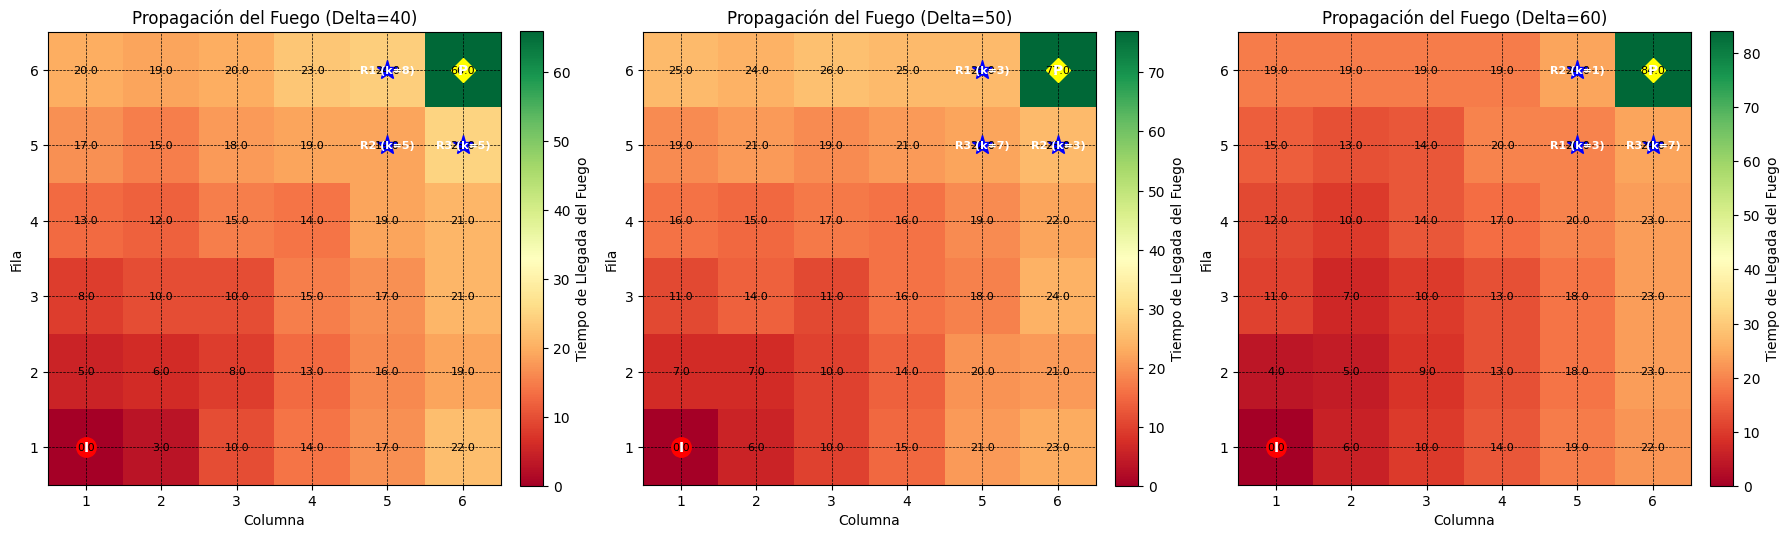

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

def run_model(Delta):
    # Definimos los parámetros del problema
    grid_size = 6  # Tamaño de la cuadrícula
    N = [(i, j) for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)]  # Nodos en una cuadrícula grid_size x grid_size

    # Arcos entre nodos adyacentes con ocho direcciones de propagación
    A = []
    for i, j in N:
        # Ocho direcciones de propagación
        directions = [
            (1, 0),   # Este
            (-1, 0),  # Oeste
            (0, 1),   # Norte
            (0, -1),  # Sur
            (1, 1),   # Noreste
            (1, -1),  # Sureste
            (-1, 1),  # Noroeste
            (-1, -1)  # Suroeste
        ]

        for dx, dy in directions:
            new_i, new_j = i + dx, j + dy
            if 1 <= new_i <= grid_size and 1 <= new_j <= grid_size:
                A.append(((i, j), (new_i, new_j)))

    # Función para calcular tiempo de propagación considerando viento, pendiente y aleatoriedad
    def calculate_propagation_time(dx, dy):
        # Simulando los tres factores mencionados en el paper
        wind_factor = 1 if dx > 0 or dy > 0 else 3
        slope_factor = np.random.randint(1, 4)
        fuel_factor = np.random.randint(1, 4)

        base_time = wind_factor + slope_factor + fuel_factor
        return base_time

    # Tiempo de propagación entre nodos
    c = {((i_start, j_start), (i_end, j_end)): calculate_propagation_time(i_end - i_start, j_end - j_start)
         for (i_start, j_start), (i_end, j_end) in A}

    # Nodo de ignición del fuego
    ignition_node = (1, 1)

    # Nodos que deben ser protegidos
    P = [(6, 6)]

    # Valor g (tiempo mínimo que el fuego debe tardar en llegar a los nodos protegidos)
    g = 50

    # Conjunto de recursos disponibles
    R = [1, 2, 3]

    # Delta: tiempo que se retrasa la propagación al colocar un recurso
    # Delta es pasado como parámetro a la función

    # Definimos el conjunto de instantes de tiempo
    T = 8  # Número total de periodos de tiempo
    K = range(1, T+1)

    # Parámetros de disponibilidad de recursos
    a_k = {k: 0 for k in K}
    a_k[1] = len(R)  # Todos los recursos disponibles en k=1

    # Parámetros de instantes de tiempo
    b_k = {k: k for k in K}  # Cada periodo representa una unidad de tiempo

    # Creamos el modelo de optimización
    m = gp.Model("Areas_Protegidas")
    m.setParam('OutputFlag', 0)  # Para suprimir la salida detallada del solver

    # Variables de decisión
    # t_i: tiempo de llegada del fuego al nodo i
    t = m.addVars(range(1, grid_size + 1), range(1, grid_size + 1), name="t", lb=0)

    # s_ij: variables de holgura
    s = m.addVars(
        [(i[0], i[1], j[0], j[1]) for i, j in A], name="s", lb=0
    )

    # q_ij: variables binarias para el flujo en el arco ij
    q = m.addVars(
        [(i[0], i[1], j[0], j[1]) for i, j in A], vtype=GRB.BINARY, name="q"
    )

    # x_ij: variables de flujo
    x = m.addVars(
        [(i[0], i[1], j[0], j[1]) for i, j in A], name="x", lb=0
    )

    # z_{ri}^k: variables binarias que indican si el recurso r está ubicado en el nodo i en el tiempo k
    z = m.addVars(
        R, range(1, grid_size + 1), range(1, grid_size + 1), K, vtype=GRB.BINARY, name="z"
    )

    # o_k: recursos no utilizados en el tiempo k
    o = m.addVars(K, lb=0, name="o")

    # Función objetivo: minimizar el número total de recursos utilizados
    m.setObjective(
        gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K),
        GRB.MINIMIZE
    )

    # Restricciones base de flujo y propagación

    # Restricción (2): Conservación de flujo en el nodo de ignición
    m.addConstr(
        -gp.quicksum(x[ignition_node[0], ignition_node[1], j[0], j[1]] for (i, j) in A if i == ignition_node) == -(len(N) - 1),
        name="FlowConservation_Ignition"
    )

    # Restricción (3): Conservación de flujo en los demás nodos
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            if (i, j) != ignition_node:
                m.addConstr(
                    -gp.quicksum(x[i, j, k, l] for (start, (k, l)) in A if start == (i, j)) +
                    gp.quicksum(x[k, l, i, j] for ((k, l), end) in A if end == (i, j)) == 1,
                    name=f"FlowConservation_{i}_{j}"
                )

    # Restricción (7): Tiempo de llegada en el nodo de ignición
    m.addConstr(t[ignition_node[0], ignition_node[1]] == 0, name="IgnitionTime")

    # Restricción (11): x_{ij} ≤ (n-1) q_{ij}
    for (i_start, j_start), (i_end, j_end) in A:
        m.addConstr(
            x[i_start, j_start, i_end, j_end] <= (len(N) - 1) * q[i_start, j_start, i_end, j_end],
            name=f"FlowLink_{i_start}_{j_start}_{i_end}_{j_end}"
        )

    # Restricción (21): Tiempo de llegada considerando la ubicación de recursos
    for (i_start, j_start), (i_end, j_end) in A:
        resource_delay = Delta * gp.quicksum(z[r, i_start, j_start, k] for r in R for k in K)
        m.addConstr(
            t[i_end, j_end] - t[i_start, j_start] + s[i_start, j_start, i_end, j_end] ==
            c[((i_start, j_start), (i_end, j_end))] + resource_delay,
            name=f"TimeArrival_{i_start}_{j_start}_{i_end}_{j_end}"
        )

    # Restricción (22): s_{ij} ≤ M (1 - q_{ij})
    M = (len(N) - 1) * max(c.values()) + len(R) * Delta
    for (i_start, j_start), (i_end, j_end) in A:
        m.addConstr(
            s[i_start, j_start, i_end, j_end] <= M * (1 - q[i_start, j_start, i_end, j_end]),
            name=f"SlackLink_{i_start}_{j_start}_{i_end}_{j_end}"
        )

    # Restricciones de recursos

    # Restricción (14): Cada recurso puede ubicarse en un solo nodo y tiempo
    for r in R:
        m.addConstr(
            gp.quicksum(z[r, i, j, k] for i in range(1, grid_size + 1) for j in range(1, grid_size + 1) for k in K) <= 1,
            name=f"Resource_{r}_UniqueLocation"
        )

    # Restricción (15): Un nodo puede tener como máximo un recurso en un tiempo dado
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            for k in K:
                m.addConstr(
                    gp.quicksum(z[r, i, j, k] for r in R) <= 1,
                    name=f"Node_{i}_{j}_SingleResource_Time_{k}"
                )

    # Restricción (16): Disponibilidad de recursos en tiempo inicial
    m.addConstr(
        gp.quicksum(z[r, i, j, 1] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[1] == a_k[1],
        name="ResourceAvailability_1"
    )

    # Restricción (17): Disponibilidad de recursos en tiempos posteriores
    for k in K[1:]:
        m.addConstr(
            gp.quicksum(z[r, i, j, k] for r in R for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)) + o[k] == a_k[k] + o[k-1],
            name=f"ResourceAvailability_{k}"
        )

    # Restricción (18): Los recursos solo pueden asignarse a nodos no quemados antes del tiempo b_k
    for r in R:
        for i in range(1, grid_size + 1):
            for j in range(1, grid_size + 1):
                for k in K:
                    m.addConstr(
                        t[i, j] >= b_k[k] * z[r, i, j, k],
                        name=f"ResourceUsage_{r}_{i}_{j}_{k}"
                    )

    # Restricción (24): Los nodos protegidos deben tener un tiempo de llegada mayor o igual a g
    for i, j in P:
        m.addConstr(t[i, j] >= g, name=f"ProtectedNode_{i}_{j}")

    # Resolución del modelo
    m.optimize()

    # Visualización
    if m.status == GRB.OPTIMAL:
        print(f"\nSolución Óptima Encontrada para Delta = {Delta}:")
        print(f"Número mínimo de recursos utilizados: {m.objVal}")

        # Extracción de ubicaciones de recursos
        resource_locations = {}
        for r in R:
            for k in K:
                for i in range(1, grid_size + 1):
                    for j in range(1, grid_size + 1):
                        if z[r, i, j, k].X > 0.5:
                            resource_locations[r] = (i, j, k)
                            print(f"Recurso {r} ubicado en el nodo ({i}, {j}) en el tiempo {k}")
                            break

        # Tiempos de llegada del fuego a cada nodo
        arrival_times = {(i, j): t[i, j].X for i in range(1, grid_size + 1) for j in range(1, grid_size + 1)}

        return arrival_times, resource_locations
    else:
        print(f"No se encontró una solución óptima para Delta = {Delta}.")
        return None, None

# Valores de Delta a probar
delta_values = [40, 50, 60]
arrival_times_list = []
resource_locations_list = []

for Delta in delta_values:
    arrival_times, resource_locations = run_model(Delta)
    arrival_times_list.append(arrival_times)
    resource_locations_list.append(resource_locations)

# Plotting las figuras una al lado de otra
fig, axs = plt.subplots(1, len(delta_values), figsize=(18, 6))
grid_size = 6  # Tamaño de la cuadrícula

for idx, Delta in enumerate(delta_values):
    arrival_times = arrival_times_list[idx]
    resource_locations = resource_locations_list[idx]
    if arrival_times is None:
        continue  # Saltar si no se encontró solución
    # Crear matriz de tiempos de llegada
    time_grid = np.zeros((grid_size, grid_size))
    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            time_grid[grid_size - i, j - 1] = arrival_times[(i, j)]
    ax = axs[idx]
    im = ax.imshow(time_grid, cmap='RdYlGn')
    ax.set_title(f'Propagación del Fuego (Delta={Delta})')
    ax.set_xlabel('Columna')
    ax.set_ylabel('Fila')
    ax.set_xticks(range(grid_size))
    ax.set_xticklabels(range(1, grid_size + 1))
    ax.set_yticks(range(grid_size))
    ax.set_yticklabels(range(grid_size, 0, -1))
    # Etiquetas de nodos
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{time_grid[i, j]:.1f}",
                    ha='center', va='center', color='black', fontsize=8)
    # Marcar nodos de recursos:
    resource_locations = resource_locations_list[idx]
    for (r, (x, y, k)) in resource_locations.items():
        ax.plot(y - 1, grid_size - x, marker='*', color='blue', markersize=15)
        ax.text(y - 1, grid_size - x, f'R{r} (k={k})', color='white',
                ha='center', va='center', fontsize=8, fontweight='bold')
    # Marcar nodo de ignición
    ignition_node = (1, 1)
    ax.plot(ignition_node[1] - 1, grid_size - ignition_node[0], 'ro', markersize=14)  # Círculo rojo
    ax.text(ignition_node[1] - 1, grid_size - ignition_node[0], 'I', color='white',
            ha='center', va='center', fontsize=10, fontweight='bold')
    # Marcar nodos protegidos
    P = [(6, 6)]
    for (i_p, j_p) in P:
        ax.plot(j_p - 1, grid_size - i_p, marker='D', color='yellow', markersize=12)  # Rombo amarillo
        ax.text(j_p - 1, grid_size - i_p, 'P', color='white',
                ha='center', va='center', fontsize=10, fontweight='bold')
    ax.grid(which='both', color='black', linewidth=0.5, linestyle='--')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Tiempo de Llegada del Fuego')

plt.tight_layout()
plt.show()
